### Import Modules and Packages

In [39]:
import os
import torch
import numpy as np
import rasterio as rio
from pathlib import Path
from matplotlib import pyplot as plt
from torchgeo.models import ResNet18_Weights
from torchgeo.trainers import SemanticSegmentationTask
from geo_inference.geo_inference import GeoInference
from script_model import ScriptModel

### Load Image and Visualize

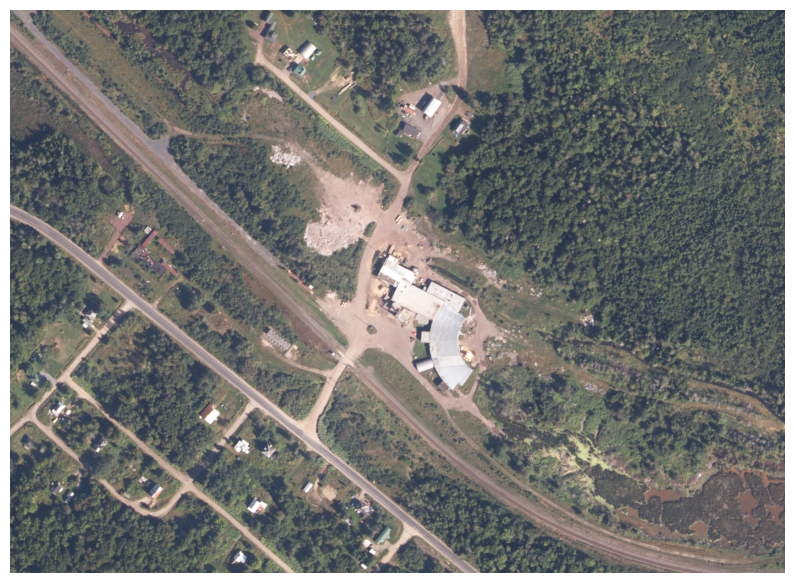

In [40]:
image_path = Path("test_small.tif")
with rio.open(image_path) as src:
    img = src.read()
    
plt.figure(figsize=(10, 10))
plt.imshow(img.transpose(1, 2, 0))
plt.axis('off')
plt.show()

### Load custom weights using TorchGeo API

In [46]:
weights = ResNet18_Weights.SENTINEL2_RGB_MOCO
input_channnels = weights.meta["in_chans"] #RGB
num_classes = 5

### Create Segmentation Model
task = SemanticSegmentationTask(model="unet",
                                backbone="resnet18",
                                weights=weights,
                                in_channels=input_channnels,
                                num_classes=num_classes,
                                loss="ce",
                                ignore_index=None,
                                lr=0.1,
                                patience=6,
                                )

model = task.model

### Script Model and save model to file

In [47]:
scripted_model = torch.jit.script(ScriptModel(model, num_classes=num_classes))
scripted_model.save("unet_resnet18.pt")

### Create GeoInference Object

In [48]:
geo_inference = GeoInference(
    model="unet_resnet18.pt",
    work_dir="./",
    batch_size=4,
    mask_to_vec=False,
    device="cpu",
    gpu_id=0
)

### Run inference on a GeoTIFF

In [49]:
geo_inference(str(image_path))

Converting RasterDataset res from 0.0 to 0.2999845242957562


extracting features:   0%|          | 0/14 [00:00<?, ?batch/s]

extracting features: 100%|██████████| 14/14 [00:05<00:00,  2.37batch/s]


[2024-05-24 11:30:39,814][geo_inference.geo_blocks][INFO] - Mask saved to test_small_mask.tif
[2024-05-24 11:30:39,816][geo_inference.geo_inference][INFO] - Extraction Completed in 0m 6s


### Load output mask and visualize

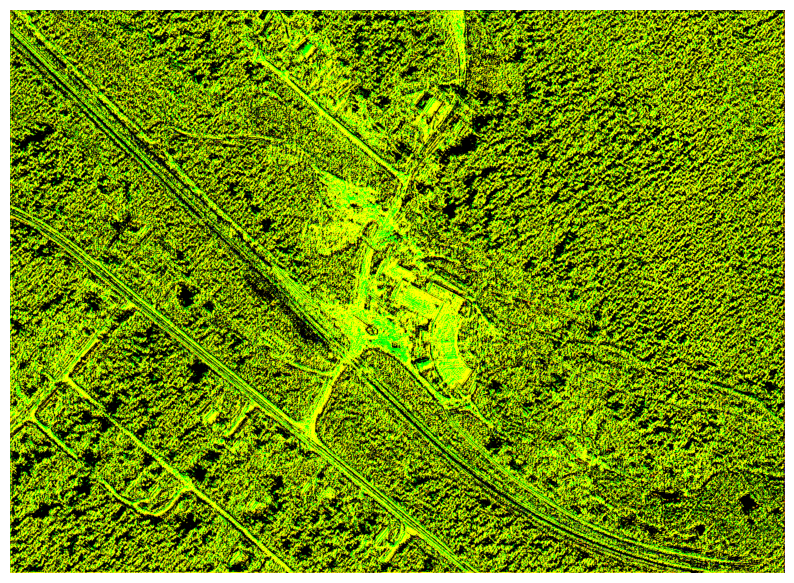

In [50]:
mask_path = Path("test_small_mask.tif")
with rio.open(mask_path) as src:
    mask = src.read()


### Visulize the mask with color code
color_code = {0: [0, 0, 0],     # Black
              1: [0, 255, 0],   # Green
              2: [0, 0, 255],   # Blue
              3: [255, 255, 0], # Yellow
              4: [255, 0, 0]    # Red
              }

colored_mask = np.zeros((*mask.squeeze(0).shape, 3), dtype=np.uint8)
for label, color in color_code.items():
    colored_mask[mask[0] == label] = color

plt.figure(figsize=(10, 10))
plt.imshow(colored_mask)
plt.axis('off')
plt.show()

In [38]:
os.remove("unet_resnet18.pt")
os.remove("test_small_mask.tif")